# Notebook 19 - Score and Filter Matches

## Purpose
This notebook scores the raw candidate matches between recipe ingredients and store products using lexical and semantic similarity techniques. It filters low-confidence or ambiguous matches and retains only the top candidates per ingredient for downstream selection and optimization.

## Objectives
- Assign similarity scores (string-based and/or embedding-based) to matched ingredient-product pairs
- Filter out noisy or irrelevant matches based on threshold rules and diagnostics
- Deduplicate candidates and retain the best match per ingredient per store
- Export a scored and filtered match table for prioritized recommendation

## Inputs
- `matching_matrix_candidates.csv` - Raw candidate pairs from concept/variant matching
- `recipes_with_variants.csv` - Ingredient metadata for contextual enrichment
- `products_with_variants.csv` - Product metadata including names and concepts

## Outputs
- `matching_matrix_scored.csv` - Cleaned and scored recipe–product match table
- Console summary of match quality distribution and filtering thresholds


In [8]:
# Compute fuzzy string similarity
from fuzzywuzzy import fuzz

def compute_fuzzy_score(row):
    name_ingredient = row["ingredient"]
    name_product = row["product_name"]
    if pd.isna(name_ingredient) or pd.isna(name_product):
        return 0
    return fuzz.token_set_ratio(str(name_ingredient), str(name_product))

df_matches["fuzzy_score"] = df_matches.apply(compute_fuzzy_score, axis=1)


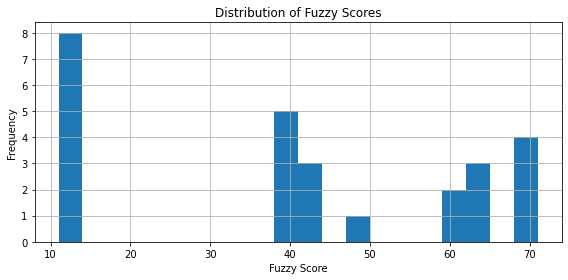

In [9]:
# Plot fuzzy score distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
df_matches["fuzzy_score"].hist(bins=20)
plt.title("Distribution of Fuzzy Scores")
plt.xlabel("Fuzzy Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
# Filter low-confidence matches
threshold = 60
df_filtered = df_matches[df_matches["fuzzy_score"] >= threshold].copy()

# Deduplicate: keep best match per recipe-row and store
df_top = (
    df_filtered
    .sort_values("fuzzy_score", ascending=False)
    .drop_duplicates(subset=["row_id", "store"])
    .reset_index(drop=True)
)

# Save result
output_folder = "matching_scored"
output_file = os.path.join(output_folder, "matching_matrix_fuzzy.csv")
df_top.to_csv(output_file, index=False)


In [16]:
# Final filtering and saving summary
print("Match filtering summary:")
print(f"- Total matches before filtering: {len(df_matches)}")
print(f"- Matches above fuzzy threshold ({threshold}): {len(df_filtered)}")
print(f"- Matches retained after deduplication: {len(df_top)}")
print(f"- Average fuzzy score (retained): {df_top['fuzzy_score'].mean():.2f}")

# Save filtered matrix
output_folder = "matching_scored"
os.makedirs(output_folder, exist_ok=True)
output_file = os.path.join(output_folder, "matching_matrix_fuzzy.csv")
df_top.to_csv(output_file, index=False)
print(f"Filtered match matrix saved to: {output_file}")


Match filtering summary:
- Total matches before filtering: 26
- Matches above fuzzy threshold (60): 9
- Matches retained after deduplication: 8
- Average fuzzy score (retained): 66.25
Filtered match matrix saved to: matching_scored\matching_matrix_fuzzy.csv
